# Rinse Over Run EDA

By Suzin

In [34]:
# Rinse Over Run

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

from IPython.display import display, HTML

pd.set_option('display.max_columns', None)

In [15]:
df = pd.read_csv("data/train_values.csv", index_col='row_id', parse_dates=['timestamp'], nrows=100000)

In [16]:
df.columns

Index(['process_id', 'object_id', 'phase', 'timestamp', 'pipeline',
       'supply_flow', 'supply_pressure', 'return_temperature',
       'return_conductivity', 'return_turbidity', 'return_flow', 'supply_pump',
       'supply_pre_rinse', 'supply_caustic', 'return_caustic', 'supply_acid',
       'return_acid', 'supply_clean_water', 'return_recovery_water',
       'return_drain', 'object_low_level', 'tank_level_pre_rinse',
       'tank_level_caustic', 'tank_level_acid', 'tank_level_clean_water',
       'tank_temperature_pre_rinse', 'tank_temperature_caustic',
       'tank_temperature_acid', 'tank_concentration_caustic',
       'tank_concentration_acid', 'tank_lsh_caustic', 'tank_lsh_acid',
       'tank_lsh_clean_water', 'tank_lsh_pre_rinse', 'target_time_period'],
      dtype='object')

In [17]:
for col in df.columns:
    if df[col].dtype == np.object:
        df.loc[:, col] = df[col].astype('category')

In [18]:
df.phase.cat.categories

Index(['acid', 'caustic', 'final_rinse', 'intermediate_rinse', 'pre_rinse'], dtype='object')

In [44]:
df.pipeline.cat.categories

Index(['L1', 'L10', 'L11', 'L2', 'L3', 'L4', 'L6', 'L7', 'L8'], dtype='object')

Some of the boolean columns were read as float, but that's fine.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 35 columns):
process_id                    100000 non-null int64
object_id                     100000 non-null int64
phase                         100000 non-null category
timestamp                     100000 non-null datetime64[ns]
pipeline                      100000 non-null category
supply_flow                   100000 non-null float64
supply_pressure               100000 non-null float64
return_temperature            100000 non-null float64
return_conductivity           100000 non-null float64
return_turbidity              100000 non-null float64
return_flow                   100000 non-null float64
supply_pump                   100000 non-null bool
supply_pre_rinse              100000 non-null bool
supply_caustic                100000 non-null bool
return_caustic                100000 non-null bool
supply_acid                   100000 non-null bool
return_acid                   100000

We notice that the division in phase isn't completely determined by the valve states. For example, during the pre-rinsing phase, for 0.8% of the time the caustic valve is open, and for 10% of the time none of the valves are open.

In [61]:
df[['phase', 'supply_pre_rinse', 'supply_caustic', 'supply_acid', 'supply_clean_water']].groupby(['phase']).mean()

,supply_pre_rinse,supply_caustic,supply_acid,supply_clean_water
phase,,,,
acid,0.000000,0.000000,0.883297,0.014974
caustic,0.000000,0.890333,0.000000,0.006128
final_rinse,0.000000,0.000000,0.000000,0.560907
intermediate_rinse,0.000000,0.000000,0.037583,0.551221
pre_rinse,0.883571,0.007619,0.000000,0.000000


But also that two valves are never open at the same time.

In [54]:
(
    (df.supply_pre_rinse) & (df.supply_caustic)
).sum(), (
    (df.supply_acid) & (df.supply_clean_water)
).sum(), (
    (df.supply_acid) & (df.supply_clean_water)
).sum()  # other combos are also 0

(0, 0, 0, 0)

In [32]:
pd.crosstab(df['phase'], df['tank_lsh_pre_rinse'])

tank_lsh_pre_rinse,0.0
phase,
acid,23307
caustic,37696
final_rinse,24291
intermediate_rinse,6306
pre_rinse,8400


`target_time_period` column seemed a little confusing. From the [competition description](https://www.drivendata.org/competitions/56/predict-cleaning-time-series/page/125/):
> `target_time_period` - Indicator (Boolean) of if the observation is included when calculating the target variable.

So only if `target_time_period` is `True` does that row count towards the target variable, `final_rinse_total_turbidity_liter`. Not all of the final rinse phase count.

In [64]:
df[(df.process_id == 20001) & (df.target_time_period == False)].tail(2)

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,supply_pump,supply_pre_rinse,supply_caustic,return_caustic,supply_acid,return_acid,supply_clean_water,return_recovery_water,return_drain,object_low_level,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1460,20001,405,final_rinse,2018-04-15 05:09:27,L4,53193.720,1.912109,70.88397,32.577740,0.437645,52394.383,True,False,False,False,False,True,True,False,False,True,55.61722,40.650860,42.240128,42.228370,33.47801,82.84867,72.80093,45.742397,44.653038,False,0.0,False,0.0,False
1461,20001,405,final_rinse,2018-04-15 05:09:29,L4,53631.367,1.900825,70.05208,12.576046,0.383391,53092.450,True,False,False,False,False,True,True,False,False,True,55.61722,40.646156,42.240128,42.221317,33.47801,82.84867,72.80093,45.735096,44.653038,False,0.0,False,0.0,False


In [65]:
df[(df.process_id == 20001) & (df.target_time_period == True)].head(2)

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,supply_pump,supply_pre_rinse,supply_caustic,return_caustic,supply_acid,return_acid,supply_clean_water,return_recovery_water,return_drain,object_low_level,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1462,20001,405,final_rinse,2018-04-15 05:09:31,L4,53765.190,1.904731,67.31770,7.588104,0.325521,52944.152,True,False,False,False,False,False,True,True,False,True,55.61722,40.641457,42.240128,42.20721,33.478010,82.85229,72.80093,45.728832,44.653038,False,0.0,False,0.0,True
1463,20001,405,final_rinse,2018-04-15 05:09:33,L4,53909.867,1.905165,62.64106,4.625165,0.311053,53530.090,True,False,False,False,False,False,True,True,False,True,55.61722,40.639107,42.240128,42.18370,33.459927,82.84867,72.80093,45.728450,44.653038,False,0.0,False,0.0,True


Let's figure out how to shape this data for RNNs. First, let's see how long each sequence is.

In [71]:
pid_lengths = [len(df[df.process_id == pid]) for pid in df.process_id.unique()]

<IPython.core.display.Javascript object>


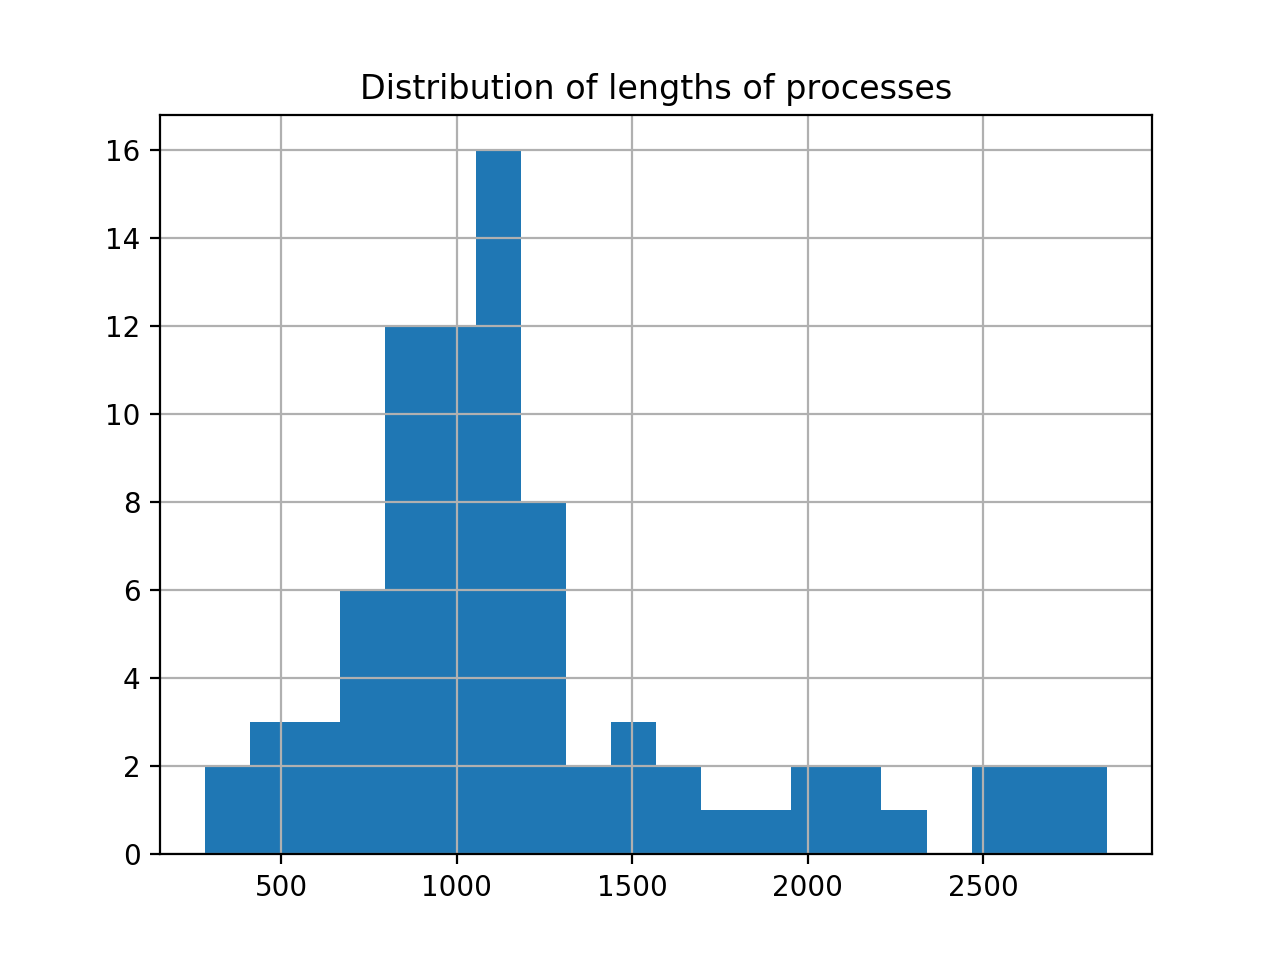

[]

In [75]:
plt.figure()
plt.title("Distribution of lengths of processes")
pd.Series(pid_lengths).hist(bins=20)
plt.plot()

Now let's figure out how long each phase is.

In [79]:
df.phase.cat.categories

Index(['acid', 'caustic', 'final_rinse', 'intermediate_rinse', 'pre_rinse'], dtype='object')

In [80]:
phases = ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid', 'final_rinse']

In [82]:
phase_lengths = dict()
for phase in phases:
    df_phase = df[df.phase == phase]
    phase_lengths[phase] = [len(df_phase[df_phase.process_id == pid]) for pid in df.process_id.unique()]

In [90]:
phase_lengths.keys()

dict_keys(['final_rinse', 'pre_rinse', 'acid', 'intermediate_rinse', 'caustic'])

<IPython.core.display.Javascript object>


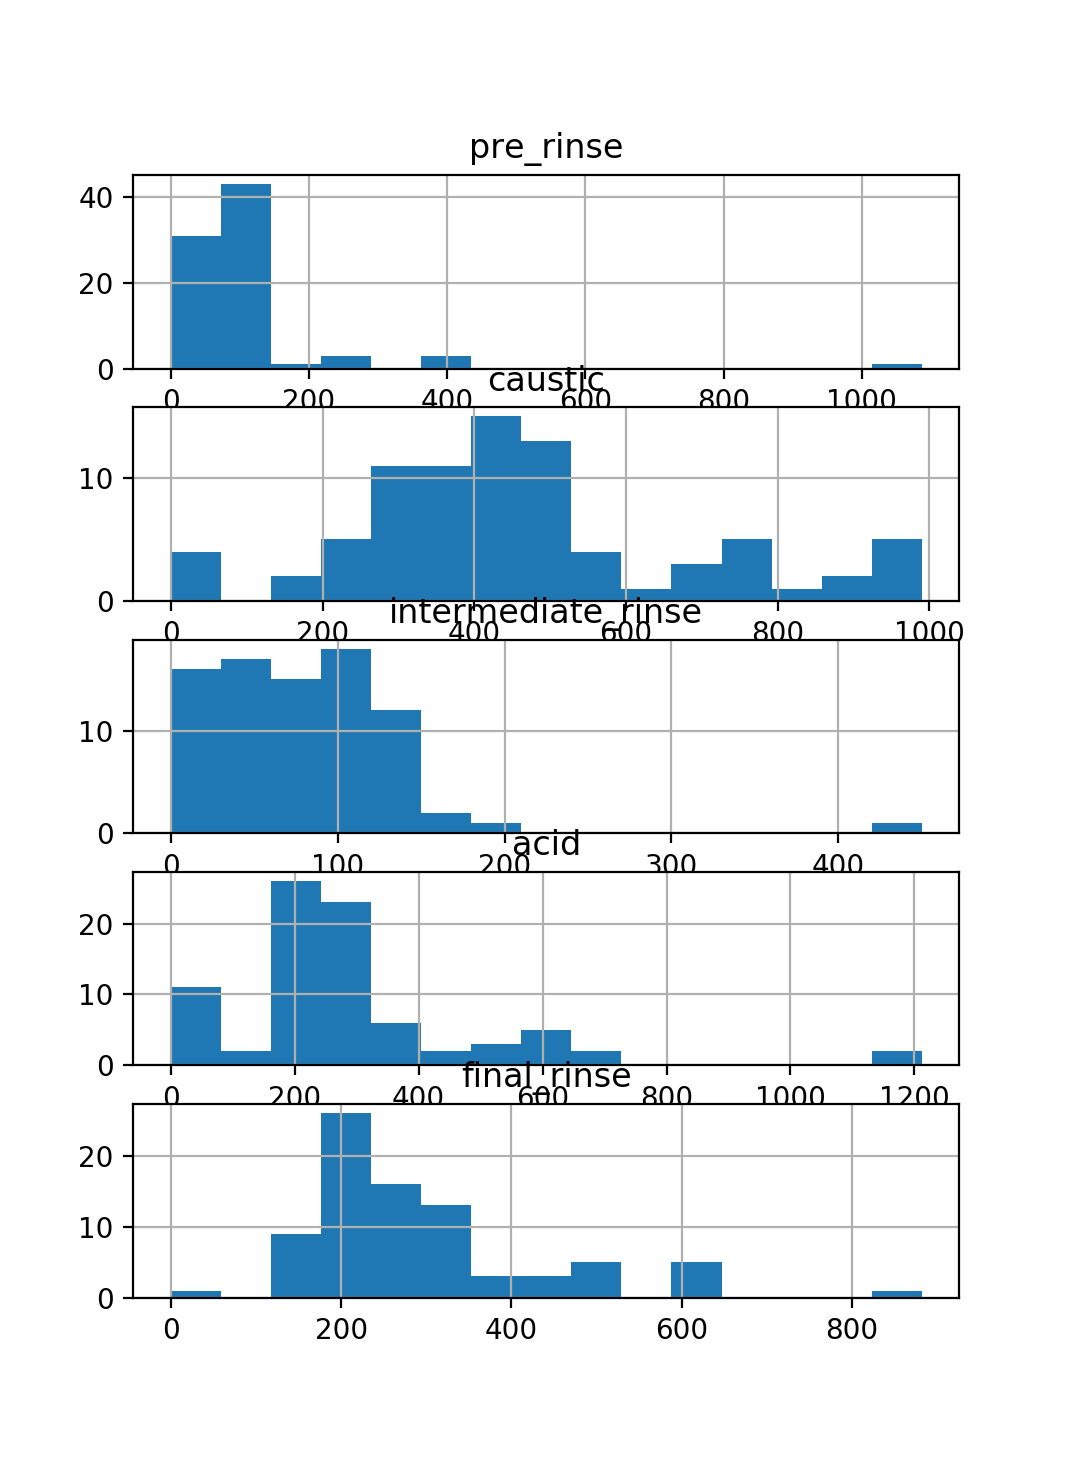

In [97]:
figs, axes = plt.subplots(len(phases))
for i, phase in enumerate(phases):
    pd.Series(phase_lengths[phase]).hist(ax=axes[i], bins=15)
    axes[i].set_title(phase)